# Main Notebook

This main notebook is simply to satisfy the requirement of having a notebook. Most of the code has been developed and run outside of notebooks as this makes more sense with a larger codebase. Additionally we train large models that requires high performance GPUs, which is not nice to do in a notebook.

In this notebook we thus show how to use our different dataloader classes and how to run our code with our make commands. 

The notebook is structure as follows:
- **Imports**: Some libraries: Both our own and other's.
- **Datasets**: Displays how to use our custom dataset classes.
- **Training models**: Some examples of how to train the models using our framework.
- **Results**: Here we show how to sample from the models, calculate FID from the samples and display samples.


## Imports

In [1]:
import torch
from torch.utils.data import DataLoader
from src.data_utils.dataloader import PokemonDataset, PokemonFusionDataset, ResizeSprite
from src.data_utils.metadata import PokemonMetaData
from src.main import build_dataset
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np

## Datasets

### Pokemon Types (label)

We have obtained labels from: 
https://gist.github.com/armgilles/194bcff35001e7eb53a2a8b441e8b2c6/archive/92200bc0a673d5ce2110aaad4544ed6c4010f687.zip

Which we have also loaded in a Metadata class as seen below. Here we have made the translation from Pokemon ID to type.

In [2]:
metadata = PokemonMetaData()

print("Available types:")
print(list(metadata.types_dict.keys()))

# convert id to type
print("\nPokemon with ID 1 is of type: ", metadata.get_type_by_id(1, numeric=False))
# NOTE This method is used within the dataloaders when creating the label

# convert type to id
label_to_idx = metadata.types_dict
# flip the dictionary
idx_to_label = {v: k for k, v in label_to_idx.items()}

Available types:
['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water']

Pokemon with ID 1 is of type:  Grass


### Original dataset

Our original dataset consists of multiple game generation Pokemon sprites. We have made a dataloader class to load the games and whether we want front facing, back facing or shiny.

First we explore the resolutions of the different generations:

In [ ]:
# First, get the data. This downloads the data from the internet and saves it to the data folder, in the correct format
!make get-data

In [3]:
def print_stats(game: str):
    root_dir = "data/raw"
    dataset = PokemonDataset(root_dir, labels=["front", "shiny"], games=[game], transform=None)

    image = dataset[0][0]
    print("   Image shape: ", image.shape)
    print("   Total images: ", len(dataset))
    
print("Generation 1")
print_stats("yellow")

print("\n * Generation 1 (Fire Red/Leaf Green)")
print_stats("firered-leafgreen")

print("\nGeneration 2 (Silver)")
print_stats("silver")

print("\n * Generation 2 (Heart Gold)")
print_stats("heartgold-soulsilver")

print("\n * Generation 3")
print_stats("emerald")

print("\n * Generation 4")
print_stats("diamond-pearl")

print("\nGeneration 5")
print_stats("black-white")

Generation 1
   Image shape:  torch.Size([3, 40, 40])
   Total images:  151

 * Generation 1 (Fire Red/Leaf Green)
   Image shape:  torch.Size([3, 64, 64])
   Total images:  306

Generation 2 (Silver)
   Image shape:  torch.Size([3, 40, 40])
   Total images:  502

 * Generation 2 (Heart Gold)
   Image shape:  torch.Size([3, 80, 80])
   Total images:  986

 * Generation 3
   Image shape:  torch.Size([3, 64, 64])
   Total images:  772

 * Generation 4
   Image shape:  torch.Size([3, 80, 80])
   Total images:  986

Generation 5
   Image shape:  torch.Size([3, 96, 96])
   Total images:  1298


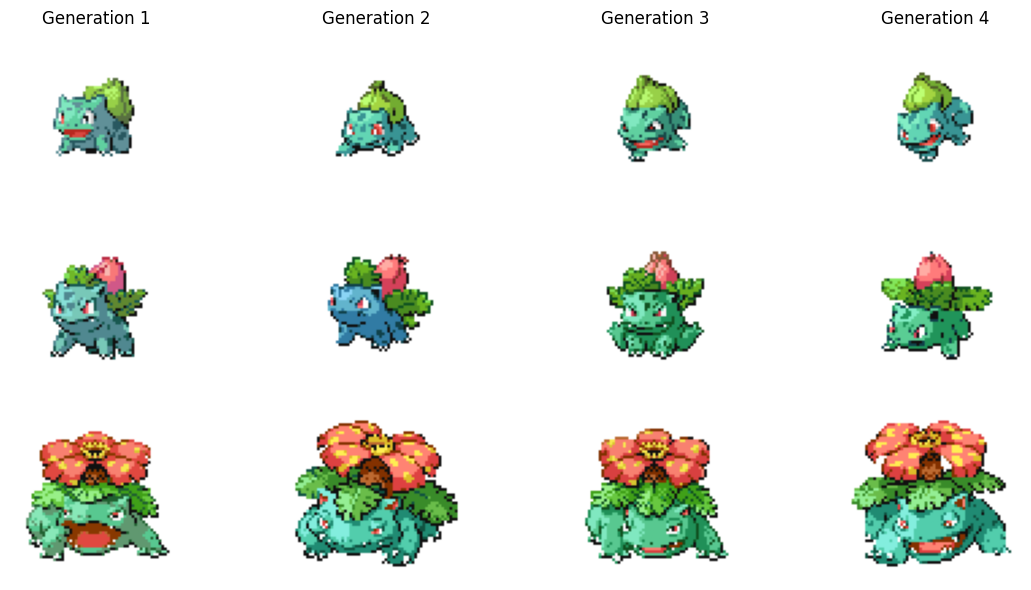

In [27]:
# Here we just plot the three datasets we decided to use with the transformations we made. See report and main.py for more details
transform = [transforms.ToTensor()]

t1 = [transforms.Pad(4, fill=255, padding_mode='constant'), ResizeSprite((64, 64))]
t1.extend(transform)
t2 = [ResizeSprite((64, 64))]
t2.extend(transform)


gen1_dataset = PokemonDataset("data/raw", labels=["front", "shiny"], games=["firered-leafgreen"], transform=transforms.Compose(t1))
gen2_dataset = PokemonDataset("data/raw", labels=["front", "shiny"], games=["heartgold-soulsilver"], transform=transforms.Compose(t2))
gen3_dataset = PokemonDataset("data/raw", labels=["front", "shiny"], games=["emerald"], transform=transforms.Compose(t1))
gen4_dataset = PokemonDataset("data/raw", labels=["front", "shiny"], games=["diamond-pearl"], transform=transforms.Compose(t2))

# plot first 3 images from each
fig, axs = plt.subplots(3, 4, figsize=(12, 6))
axs[0, 0].set_title("Generation 1")
axs[0, 1].set_title("Generation 2")
axs[0, 2].set_title("Generation 3")
axs[0, 3].set_title("Generation 4")

for i in range(3):
    axs[i, 0].imshow(gen1_dataset[i][0].permute(1, 2, 0))
    axs[i, 1].imshow(gen2_dataset[i][0].permute(1, 2, 0))
    axs[i, 2].imshow(gen3_dataset[i][0].permute(1, 2, 0))
    axs[i, 3].imshow(gen4_dataset[i][0].permute(1, 2, 0))
# remove axis
for ax in axs.flatten():
    ax.axis('off')

plt.tight_layout()

plt.savefig("figures/orig_dataset_comparison.pdf", format="pdf", dpi=300, bbox_inches='tight')

 We have only included front and shiny sprites from the games "emerald", "firered-leafgreen", "diamond-pearl", and "heartgold-soulsilver".
 Some randomly shuffled samples are plotted below from this subset which is our final original dataset. Se the report or the build_dataset class for details on how we resized the images ot 64x64.

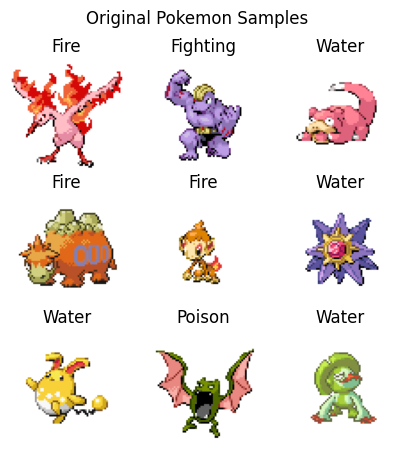

In [18]:
# Build the two datasets. See build dataset for transformation details
orig_data = build_dataset("original")
# Make dataloader
orig_loader = DataLoader(orig_data, batch_size=9, shuffle=True)

# Get the first batch of images and labels
orig_batch_imgs, orig_batch_labels = next(iter(orig_loader))

# plot in two 3x3 grid
fig, axs = plt.subplots(3, 3, figsize=(5, 5))
axs = axs.flatten()

# plot original images
for i in range(len(orig_batch_imgs)):
    img = orig_batch_imgs[i].permute(1, 2, 0)
    axs[i].imshow(img)
    lab = orig_batch_labels[i].item()
    axs[i].set_title(idx_to_label[lab])
    axs[i].axis("off")

plt.suptitle("Original Pokemon Samples")
# save to figure
plt.savefig("figures/original_dataset_samples.pdf", format="pdf", dpi=300, bbox_inches="tight", pad_inches=0.1)

### Fusion dataset

We have scraped additional fan made Pokemon fusions from: https://fusioncalc.com/. Here we only scrape fusions between Pokemon of the same type.

We have already scraped the data and it can be downloaded from our GDrive with the following make command:

In [ ]:
# Run make command to download the dataset
!make get-fusion-data

Alternatively the data can be scraped using (!!be aware that you will be making around 6000 queries to the website!!):

In [ ]:
!make scrape-fusion-data

Some Fusion dataset samples are plotted below

Fused images have resolution:  torch.Size([3, 64, 64])


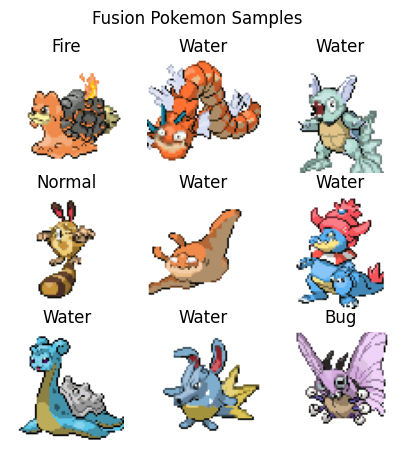

In [32]:
# Build the dataset with our method from main.py
fusion_data = build_dataset("fusion")

# Create a dataloader with batch size 9 for visualization
fusion_loader = DataLoader(fusion_data, batch_size=9, shuffle=True)

# Get a batch of data
fusion_batch_imgs, fusion_batch_labels = next(iter(fusion_loader))

# plot in two 3x3 grid
fig, axs = plt.subplots(3, 3, figsize=(5,5))
axs = axs.flatten()

# plot original images
for i in range(len(fusion_batch_imgs)):
    img = fusion_batch_imgs[i].permute(1, 2, 0)
    axs[i].imshow(img)
    lab = fusion_batch_labels[i].item()
    axs[i].set_title(idx_to_label[lab])
    axs[i].axis("off")

plt.suptitle("Fusion Pokemon Samples")
# save to figure for report
plt.savefig("figures/fusion_dataset_samples.pdf", format="pdf", dpi=300, bbox_inches="tight", pad_inches=0.1)


# resolution of fused images
print("Fused images have resolution: ", fusion_batch_imgs[0].shape)

### Our final Dataloader

These two dataset are merged into one, which we have done in main.py

Text(0.5, 0.98, 'Final Dataset Samples')

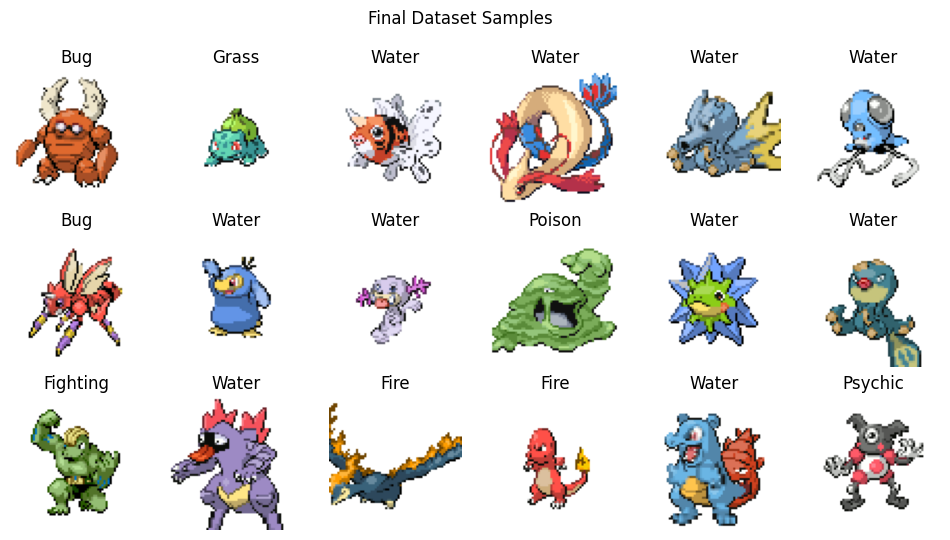

In [34]:
final_dataset = build_dataset("all")


# Create a dataloader with batch size 9 for visualization
final_loader = DataLoader(final_dataset, batch_size=18, shuffle=True)

# Get a batch of data
final_batch_imgs, final_batch_labels = next(iter(final_loader))

# plot in two 3x3 grid
fig, axs = plt.subplots(3, 6, figsize=(12,6))
axs = axs.flatten()

# plot original images
for i in range(len(final_batch_imgs)):
    img = final_batch_imgs[i].permute(1, 2, 0)
    axs[i].imshow(img)
    lab = final_batch_labels[i].item()
    axs[i].set_title(idx_to_label[lab])
    axs[i].axis("off")

plt.suptitle("Final Dataset Samples")

In [42]:
print("Total number of images in final dataset: ", len(final_dataset))

Total number of images in final dataset:  8385


### Type distribution

In [39]:
# count each type in the final dataset

type_counts = {k: 0 for k in metadata.types_dict.keys()}
for _, lab in final_dataset:
    type_counts[idx_to_label[lab]] += 1

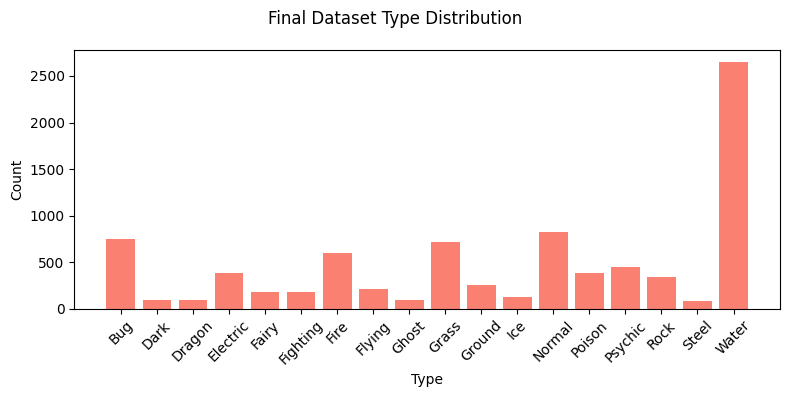

In [41]:
# make histogram
fig, ax = plt.subplots()
ax.bar(type_counts.keys(), type_counts.values(), color="salmon")
ax.set_ylabel("Count")
ax.set_xlabel("Type")
plt.xticks(rotation=45)

# figsize for report
plt.gcf().set_size_inches(8, 4)

plt.suptitle("Final Dataset Type Distribution")
plt.tight_layout()
plt.savefig("figures/type_dist.pdf", format="pdf", dpi=300, bbox_inches="tight", pad_inches=0.1)

## Training models

### VAE

Arguments for training the VAE are hardcoded into the Makefile and can be changed within the Makefile. However running the make train-vae is not recommended as it takes 30-120 minutes, on the DTU HPC with a NVIDIA A100 GPU with 40 GB of DRAM, depending on the dataset used.

In [ ]:
# Make script
!make train-vae

For submitting a VAE training job script on the DTU HPC one can select the following arguments: the model type (in this case VAE), the dataset to train on and lastly the probability of doing unconditional generation. It is not recommended to run this in the notebook as it submits a job to the DTU HPC queue!

In [ ]:
# Job script example
!./jobscript/submit_train_job.sh VAE all 0.1

### DDPM

Arguements for training the DDPM are hardcoded into the Makefile and can be changed within the Makefile. However running the make train-ddpm is not recommended as it takes 8-10 hours, on the DTU HPC with a NVIDIA A100 GPU with 40 GB of DRAM, depending on the dataset used.

In [ ]:
# Make script
!make train-ddpm

For submitting a DDPM training job script on the DTU HPC one can select the following arguments: the model type (in this case DDPM), the dataset to train on and lastly the probability of doing unconditional generation. It is not recommended to run this in the notebook as it submits a job to the DTU HPC queue!

In [ ]:
!./jobscript/submit_train_job.sh DDPM all 0.1

## Results

### Sample from each trained model

First we sample from the three trained VAEs. Replace the checkpoints with the checkpoint path of the trained models.

In [55]:
# VAE (Std. Gaussian Prior) samples
!make sample-vae ARGS="--load-weights checkpoints/VAE/f05c86aa-7700-4020-bd6d-51f0a99dc598/checkpoint_399epochs.pt --vae-prior std_gauss --sample-batch-size 256"

# VAE (MoG Prior) samples
!make sample-vae ARGS="--load-weights checkpoints/VAE/da434774-434e-41f6-b44f-d2a35ac93288/checkpoint_399epochs.pt --vae-prior mog --sample-batch-size 256"

# VAE (VampPrior) samples
!make sample-vae ARGS="--load-weights checkpoints/VAE/a2e2c504-20ad-4720-b0a5-6d87cf073d88/checkpoint_399epochs.pt --vae-prior vamp --sample-batch-size 256"

python src/main.py sample --model-type VAE --data-type all \
	 --num-samples 10000 --load-weights checkpoints/VAE/f05c86aa-7700-4020-bd6d-51f0a99dc598/checkpoint_399epochs.pt --vae-prior std_gauss --sample-batch-size 256


Sampling using weights: checkpoints/VAE/f05c86aa-7700-4020-bd6d-51f0a99dc598/checkpoint_399epochs.pt
python src/main.py sample --model-type VAE --data-type all \
	 --num-samples 10000 --load-weights checkpoints/VAE/da434774-434e-41f6-b44f-d2a35ac93288/checkpoint_399epochs.pt --vae-prior mog --sample-batch-size 256
Sampling using weights: checkpoints/VAE/da434774-434e-41f6-b44f-d2a35ac93288/checkpoint_399epochs.pt
python src/main.py sample --model-type VAE --data-type all \
	 --num-samples 10000 --load-weights checkpoints/VAE/a2e2c504-20ad-4720-b0a5-6d87cf073d88/checkpoint_399epochs.pt --vae-prior vamp --sample-batch-size 256
Sampling using weights: checkpoints/VAE/a2e2c504-20ad-4720-b0a5-6d87cf073d88/checkpoint_399epochs.pt


Sample from DDPM. This takes a long time and we suggest that you do it on a GPU.

In [ ]:
!sample-ddpm ARGS="--load-weights weights/DDPM_weights_3ceac9f4-22a0-41ec-91c3-cfc20b891675.pt --sample-batch-size 64"

We have also run jobs on the DTU HPC for this. See the README in the jobscripts folder for more details.

### Visualize samples

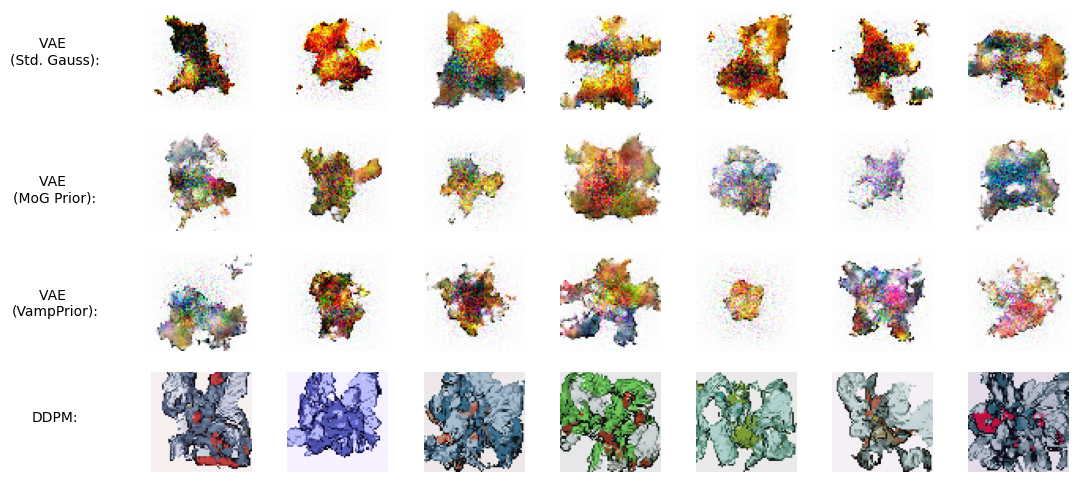

In [64]:
from src.data_utils.samples_dataloader import SamplesDataset

num_samples = 7

vae_std_path = "samples/VAE/f05c86aa-7700-4020-bd6d-51f0a99dc598"
vae_std_dataset = SamplesDataset(vae_std_path)
vae_std_dataloader = DataLoader(vae_std_dataset, batch_size=num_samples, shuffle=True)

vae_mog_path = "samples/VAE/da434774-434e-41f6-b44f-d2a35ac93288"
vae_mog_dataset = SamplesDataset(vae_mog_path)
vae_mog_dataloader = DataLoader(vae_mog_dataset, batch_size=num_samples, shuffle=True)

vae_vamp_path = "samples/VAE/a2e2c504-20ad-4720-b0a5-6d87cf073d88"
vae_vamp_dataset = SamplesDataset(vae_vamp_path)
vae_vamp_dataloader = DataLoader(vae_vamp_dataset, batch_size=num_samples, shuffle=True)

ddpm_path = "samples_cond/DDPM/344b68a7-1516-411d-898b-fb3a643dfb02"
ddpm_dataset = SamplesDataset(ddpm_path)
ddpm_dataloader = DataLoader(ddpm_dataset, batch_size=num_samples, shuffle=True)


batch_vae_std, batch_vae_std_labels = next(iter(vae_std_dataloader))
batch_vae_mog, batch_vae_mog_labels = next(iter(vae_mog_dataloader))
batch_vae_vamp, batch_vae_vamp_labels = next(iter(vae_vamp_dataloader))
batch_ddpm, batch_ddpm_labels = next(iter(ddpm_dataloader))

# clip to 0-1
batch_vae_std = torch.clamp(batch_vae_std, 0, 1)
batch_vae_mog = torch.clamp(batch_vae_mog, 0, 1)
batch_vae_vamp = torch.clamp(batch_vae_vamp, 0, 1)
# batch_ddpm = torch.clamp(batch_ddpm, 0, 1)


# Create the subplots
fig, axs = plt.subplots(4, num_samples, figsize=(12, 6))

# Plot the datasets
for i in range(num_samples):
    axs[0, i].imshow(batch_vae_std[i].permute(1, 2, 0))
    axs[1, i].imshow(batch_vae_mog[i].permute(1, 2, 0))
    axs[2, i].imshow(batch_vae_vamp[i].permute(1, 2, 0))
    axs[3, i].imshow(batch_ddpm[i].permute(1, 2, 0))

# Add text to the left of each row
fig.text(0.05, 0.85-0.04, "VAE \n(Std. Gauss):", va='center', ha='center', rotation='horizontal')
fig.text(0.05, 0.62-0.04, "VAE \n(MoG Prior):", va='center', ha='center', rotation='horizontal')
fig.text(0.05, 0.39, "VAE \n(VampPrior):", va='center', ha='center', rotation='horizontal')
fig.text(0.05, 0.16+0.04, "DDPM:", va='center', ha='center', rotation='horizontal')

# no axis
for ax in axs.flatten():
    ax.axis('off')

# plt.tight_layout()
plt.savefig("figures/samples_vae_ddpm.pdf", format="pdf", dpi=300, bbox_inches='tight')

### Calculate FID scores

#### Unconditional

Calculate FID scores for the three VAE model samples

In [2]:
# VAE (Std. Gaussian Prior) FID
!make calculate-fid ARGS="--samples-folder samples/VAE/f05c86aa-7700-4020-bd6d-51f0a99dc598"

# VAE (MoG Prior) FID
!make calculate-fid ARGS="--samples-folder samples/VAE/da434774-434e-41f6-b44f-d2a35ac93288"

# VAE (VampPrior) FID
!make calculate-fid ARGS="--samples-folder samples/VAE/a2e2c504-20ad-4720-b0a5-6d87cf073d88"

python src/calculate_fid.py --samples-folder samples/VAE/f05c86aa-7700-4020-bd6d-51f0a99dc598


Processing Real Images: 100%|█████████████████| 263/263 [00:39<00:00,  6.63it/s]
FID Score: tensor(295.2798)
python src/calculate_fid.py --samples-folder samples/VAE/da434774-434e-41f6-b44f-d2a35ac93288
Processing Real Images: 100%|█████████████████| 263/263 [00:39<00:00,  6.60it/s]
FID Score: tensor(318.1047)
python src/calculate_fid.py --samples-folder samples/VAE/a2e2c504-20ad-4720-b0a5-6d87cf073d88
Processing Real Images: 100%|█████████████████| 263/263 [00:39<00:00,  6.60it/s]
FID Score: tensor(325.3416)


Calculate FID scores for the DDPM samples

In [136]:
# DDPM samples
!make calculate-fid ARGS="--samples-folder samples/DDPM/344b68a7-1516-411d-898b-fb3a643dfb02"

python src/calculate_fid.py --samples-folder samples/DDPM/344b68a7-1516-411d-898b-fb3a643dfb02


python(7573) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Processing Real Images: 100%|█████████████████| 263/263 [00:39<00:00,  6.67it/s]
FID Score: tensor(127.8635)


In [137]:
!make calculate-fid ARGS="--samples-folder samples/DDPM/344b68a7-1516-411d-898b-fb3a643dfb02 --dataset fusion"

python src/calculate_fid.py --samples-folder samples/DDPM/344b68a7-1516-411d-898b-fb3a643dfb02 --dataset fusion


python(7636) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Processing Real Images: 100%|█████████████████| 167/167 [00:25<00:00,  6.58it/s]
FID Score: tensor(129.9928)


In [139]:
!make calculate-fid ARGS="--samples-folder samples/DDPM/344b68a7-1516-411d-898b-fb3a643dfb02 --dataset original"

python src/calculate_fid.py --samples-folder samples/DDPM/344b68a7-1516-411d-898b-fb3a643dfb02 --dataset original


python(7711) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Processing Real Images: 100%|███████████████████| 96/96 [00:14<00:00,  6.64it/s]
FID Score: tensor(131.8363)


#### Conditional

Now calculate the FID scores for the conditional samples


In [134]:
!make calculate-fid ARGS="--samples-folder samples_cond/DDPM/344b68a7-1516-411d-898b-fb3a643dfb02 --between-types"

python src/calculate_fid.py --samples-folder samples_cond/DDPM/344b68a7-1516-411d-898b-fb3a643dfb02 --between-types


python(6332) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Processing Real Images: 100%|███████████████████| 24/24 [00:03<00:00,  6.34it/s]
FID Score between Bug types: 150.29391479492188
Processing Real Images: 100%|█████████████████████| 3/3 [00:00<00:00,  4.46it/s]
FID Score between Dark types: 215.2540283203125
Processing Real Images: 100%|█████████████████████| 3/3 [00:00<00:00,  4.39it/s]
FID Score between Dragon types: 206.82803344726562
Processing Real Images: 100%|███████████████████| 13/13 [00:02<00:00,  5.78it/s]
FID Score between Electric types: 189.4207763671875
Processing Real Images: 100%|█████████████████████| 6/6 [00:01<00:00,  5.04it/s]
FID Score between Fairy types: 198.6547393798828
Processing Real Images: 100%|█████████████████████| 6/6 [00:01<00:00,  5.03it/s]
FID Score between Fighting types: 171.25204467773438
Processing Real Images: 100%|███████████████████| 19/19 [00:03<00:00,  6.00it/s]
FID Score between Fire types: 134.3279266357422
Processing Real Images: 100%|█████████████████████| 7/7 [00:01<00:00,  5.15it/s]
FID

In [135]:
!make calculate-fid ARGS="--samples-folder samples_cond/DDPM/344b68a7-1516-411d-898b-fb3a643dfb02 --between-types --dataset fusion"

python src/calculate_fid.py --samples-folder samples_cond/DDPM/344b68a7-1516-411d-898b-fb3a643dfb02 --between-types --dataset fusion


python(6520) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Processing Real Images: 100%|███████████████████| 16/16 [00:02<00:00,  6.13it/s]
FID Score between Bug types: 157.63072204589844
Processing Real Images: 100%|█████████████████████| 1/1 [00:00<00:00,  2.70it/s]
FID Score between Dark types: 285.4320983886719
Processing Real Images: 100%|█████████████████████| 1/1 [00:00<00:00,  2.71it/s]
FID Score between Dragon types: 241.87628173828125
Processing Real Images: 100%|█████████████████████| 8/8 [00:01<00:00,  5.43it/s]
FID Score between Electric types: 197.33062744140625
Processing Real Images: 100%|█████████████████████| 4/4 [00:00<00:00,  6.57it/s]
FID Score between Fairy types: 210.581298828125
Processing Real Images: 100%|█████████████████████| 3/3 [00:00<00:00,  4.07it/s]
FID Score between Fighting types: 185.54843139648438
Processing Real Images: 100%|███████████████████| 13/13 [00:02<00:00,  5.82it/s]
FID Score between Fire types: 139.47836303710938
Processing Real Images: 100%|█████████████████████| 4/4 [00:01<00:00,  3.79it/s]
FI

### Condtional sampling

!!! TODO !!!

In [122]:
cond_dataset_path = "samples_cond/DDPM/344b68a7-1516-411d-898b-fb3a643dfb02"
cond_dataset = SamplesDataset(cond_dataset_path)
cond_dataloader = DataLoader(cond_dataset, batch_size=num_samples, shuffle=True)

batch_cond, batch_cond_labels = next(iter(cond_dataloader))


all_data = []
all_labels = []

for data, labels in cond_dataloader:
    all_data.append(data)
    all_labels.append(labels)

# Concatenate all batches
all_data = torch.cat(all_data)
all_labels = torch.cat(all_labels)


# Sort the data by labels
sorted_indices = torch.argsort(all_labels)
sorted_data = all_data[sorted_indices]
sorted_labels = all_labels[sorted_indices]

num_classes = sorted_labels.max().item() + 1
grouped_data = [[] for _ in range(num_classes)]

for data, label in zip(sorted_data, sorted_labels):
    grouped_data[label].append(data)

# Convert lists to tensors
grouped_data = [torch.stack(group) for group in grouped_data]


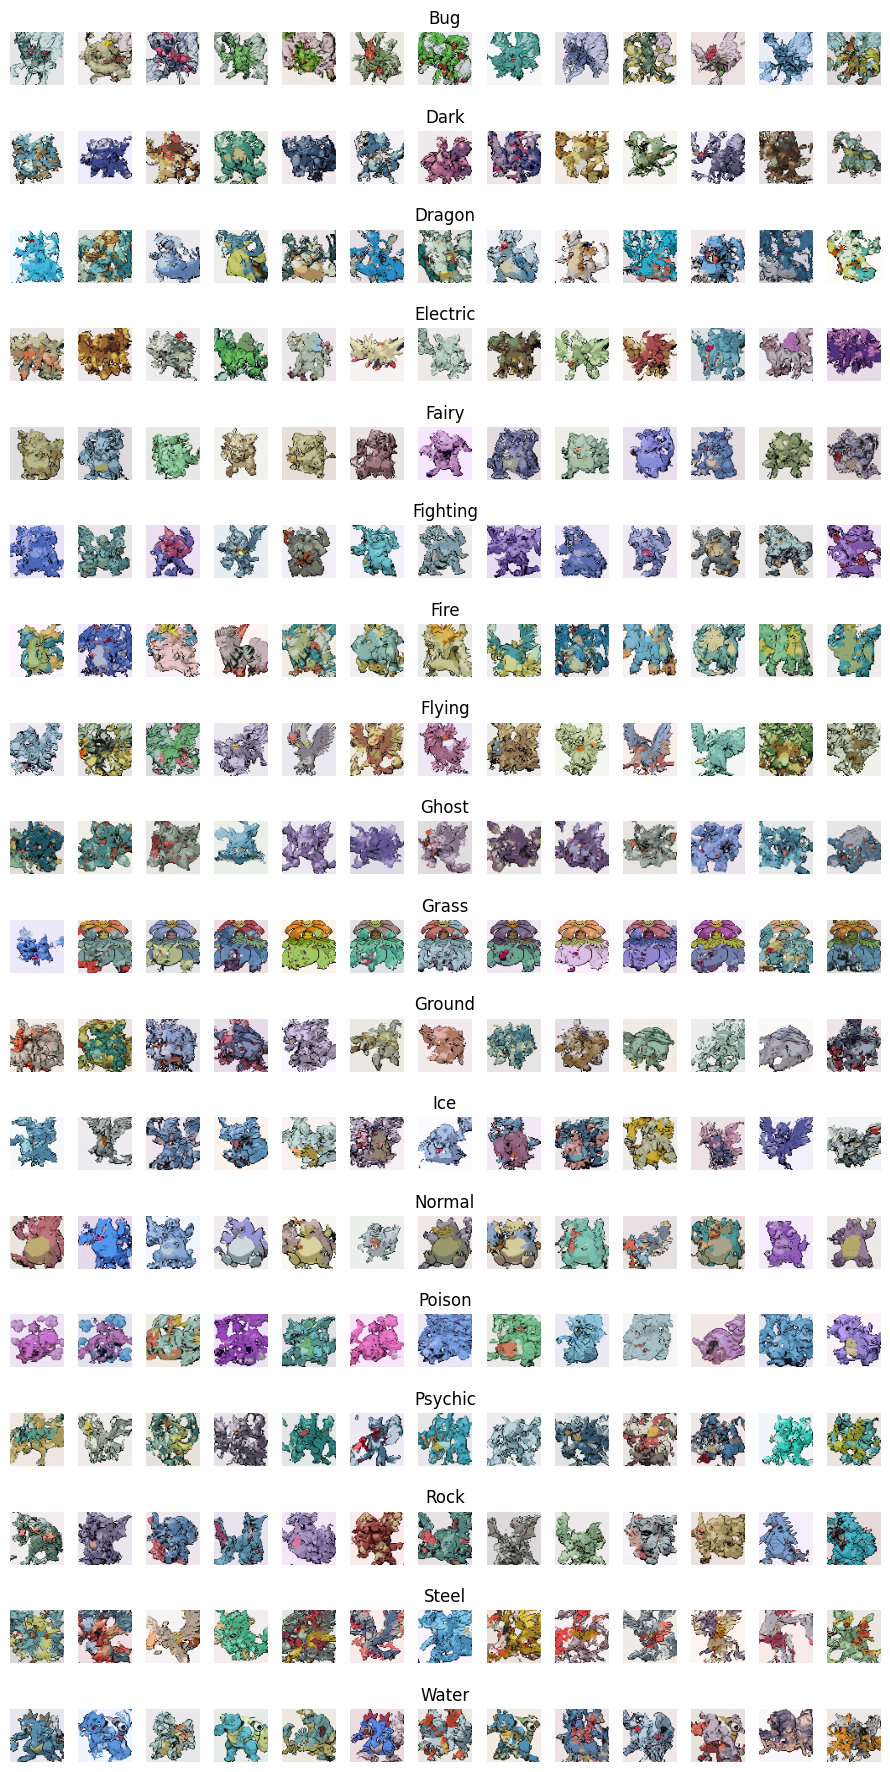

In [123]:
metadata = PokemonMetaData()
idx_to_label = {v: k for k, v in metadata.types_dict.items()}


num_samples = 13

num_classes = len(grouped_data) if len(grouped_data) != 1 else 2
fig, axs = plt.subplots(num_classes, num_samples, figsize=(9, num_classes))


for i, group in enumerate(grouped_data):
    # Create the subplots

    # Plot the datasets
    for j in range(num_samples):
        axs[i,j].imshow(group[j].permute(1, 2, 0))

    # Add title to middle image
    axs[i, num_samples//2].set_title(idx_to_label[i])

    # no axis
    for ax in axs.flatten():
        ax.axis('off')

plt.tight_layout()
plt.savefig(f"figures/cond_samples_all.pdf", format="pdf", dpi=300, bbox_inches='tight')


Plot them row-wise

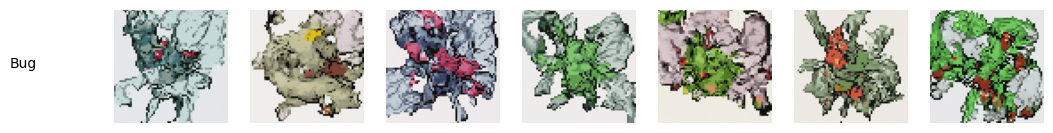

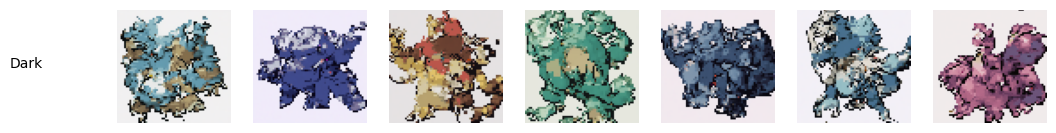

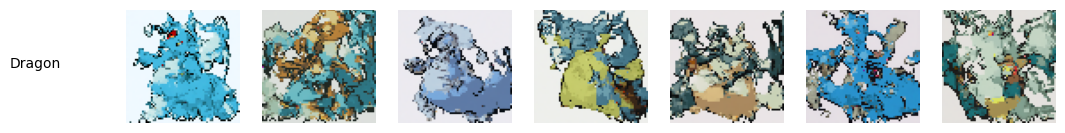

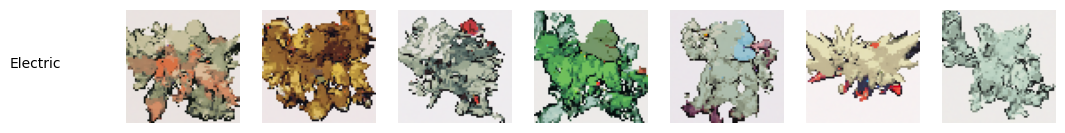

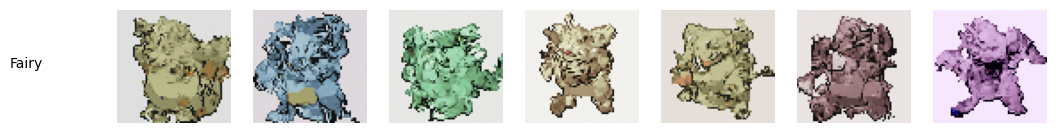

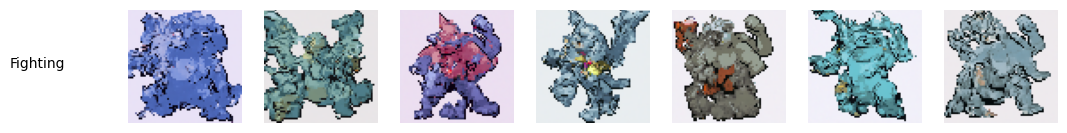

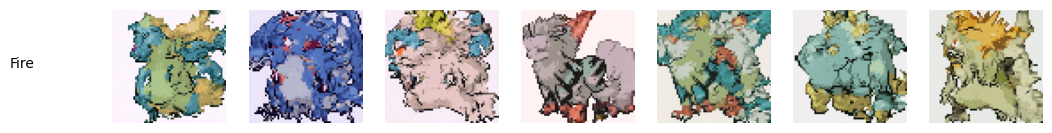

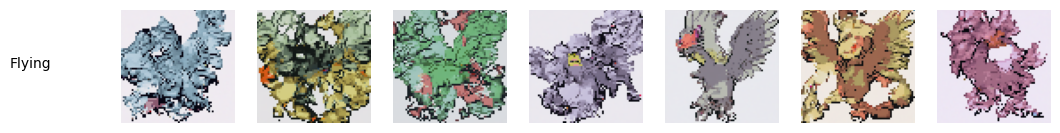

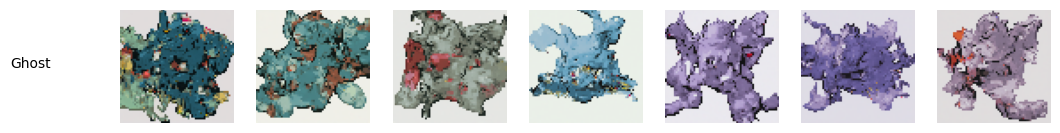

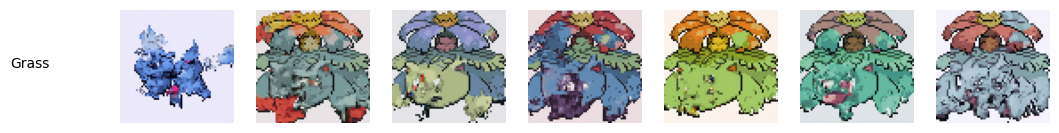

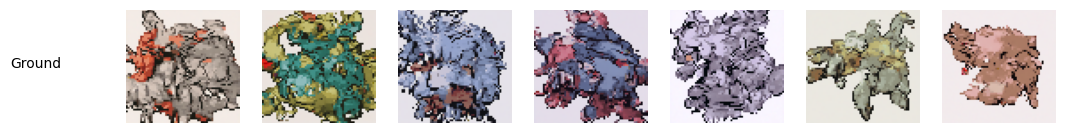

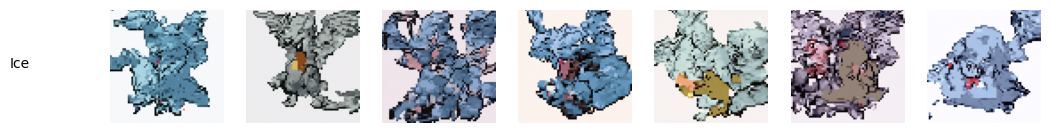

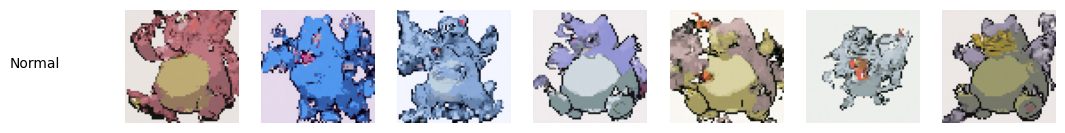

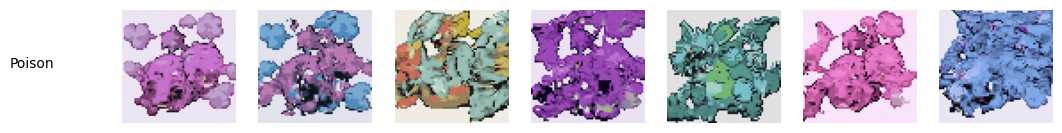

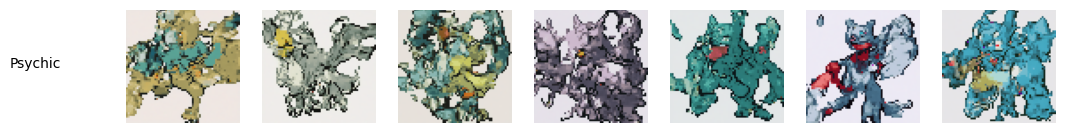

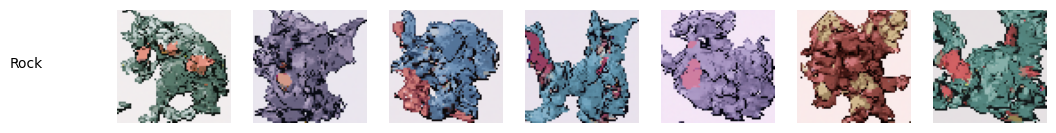

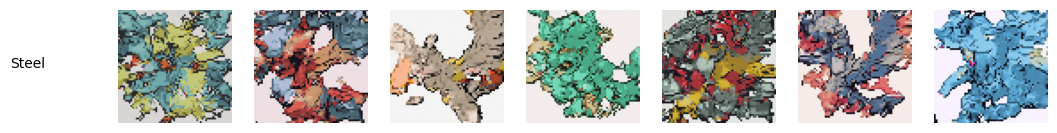

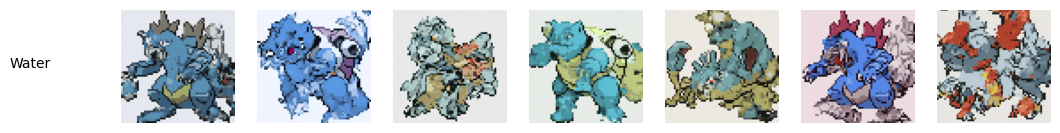

In [124]:
# One row for each type

num_samples = 7
for i, group in enumerate(grouped_data):
    # Create the subplots
    fig, axs = plt.subplots(1, num_samples, figsize=(12, 6))

    # Plot the datasets
    for j in range(num_samples):
        axs[j].imshow(group[j].permute(1, 2, 0))

    # Add text to the left of each row
    fig.text(0.05, 0.5, idx_to_label[i], va='center', ha='center', rotation='horizontal')

    # no axis
    for ax in axs.flatten():
        ax.axis('off')

    plt.savefig(f"figures/cond_samples_{idx_to_label[i]}.pdf", format="pdf", dpi=300, bbox_inches='tight')